In [20]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from glob import glob
import yaml
import json
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch
from epsilon_transformers.process.GHMM import TransitionMatrixGHMM
from epsilon_transformers.process.MixedStateTree import MixedStateTree
from sklearn.decomposition import PCA
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from tqdm.auto import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from epsilon_transformers.process.transition_matrices import get_matrix_from_args
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
DATA_DIR = Path("../data")
SWEEP_DIR = Path(DATA_DIR, '20241010223942') #Path(DATA_DIR, "20241009234307")

# sweep config
#with open(Path(SWEEP_DIR, "sweep_config.yaml"), 'r') as file:
#    sweep_config = yaml.load(file, Loader=yaml.FullLoader)

# get all folders in the sweep directory
sweep_folders = [f for f in glob(str(SWEEP_DIR / "*")) if Path(f).is_dir()]
#print(sweep_config)



In [30]:

def load_model_from_run_folder(run_folder, device='cpu'):
    # run config
    with open(Path(run_folder, "run_config.yaml"), 'r') as file:
        run_config = yaml.load(file, Loader=yaml.FullLoader)

    # model config is hooked_model_config.json
    with open(Path(run_folder, "hooked_model_config.json"), 'r') as file:
        model_config = json.load(file)

    save_pts = glob(str(Path(run_folder) / "*.pt"))
    save_pts = sorted(save_pts, key=lambda x: int(x.split('/')[-1].split('.')[0]))

    model_config['dtype'] = getattr(torch, model_config['dtype'].split('.')[-1])
    model_config['device'] = device

    model_config = HookedTransformerConfig(**model_config)

    # load the model
    model = HookedTransformer(model_config)

    return model, save_pts, run_config


def load_model_checkpoint(model, save_pts, idx):
    # load the last model checkpoint
    model.load_state_dict(torch.load(save_pts[idx], map_location='cpu'))
    return model

def get_msp(run_config):
    T = get_matrix_from_args(**run_config['process_config'])
    ghmm = TransitionMatrixGHMM(T)
    ghmm.name = 'GHMM'
    msp = ghmm.derive_mixed_state_tree(depth=run_config['model_config']['n_ctx'])
    return msp

def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions


def run_model_with_cache(model, transformer_inputs, batch_size=500, act_name='ln_final.hook_normalized'):
    transformer_inputs = torch.tensor(transformer_inputs)
    all_cache = {}
    
    for i in tqdm(range(0, transformer_inputs.shape[0], batch_size)):
        _, cache = model.run_with_cache(transformer_inputs[i:i+batch_size], names_filter=lambda name: act_name in name)
        if i == 0:
            keys = cache.keys()
            all_cache = {key: [] for key in keys}
        for key in keys:
            all_cache[key].append(cache[key])

    for key in keys:
        all_cache[key] = torch.cat(all_cache[key], dim=0)
    
    return all_cache


def plot_belief_predictions(belief_predictions,
                            transformer_input_beliefs, 
                            transformer_input_belief_indices, 
                            type='tom',
                            title=None):
    belief_predictions_flat = belief_predictions.reshape(-1, belief_predictions.shape[-1])
    transformer_input_beliefs_flat = transformer_input_beliefs.reshape(-1, transformer_input_beliefs.shape[-1]).cpu().numpy()
    # Compute distances from origin for true beliefs
    distances = np.sqrt(np.sum(transformer_input_beliefs_flat[:, 1:]**2, axis=1))
    belief_indices = transformer_input_belief_indices.cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    if type == 'tom':
        inds = [1,2]
        s = [1, .1] # size of points
        alpha = [.1, .1] # transparency of points
        com = False
        c = distances
    elif type == 'fanizza':
        inds = [1,2]
        s = [15, 1]
        alpha = [.5, .1]
        com = True
        c = belief_indices.flatten()
    elif type == 'post':
        inds = [1,2]
        s = [15, 5]
        alpha = [.1, .1]
        com = False
        c = distances
    # Determine common limits
    x_min = min(transformer_input_beliefs_flat[:, inds[0]].min(), belief_predictions_flat[:, inds[0]].min())
    x_max = max(transformer_input_beliefs_flat[:, inds[0]].max(), belief_predictions_flat[:, inds[0]].max())
    y_min = min(transformer_input_beliefs_flat[:, inds[1]].min(), belief_predictions_flat[:, inds[1]].min())
    y_max = max(transformer_input_beliefs_flat[:, inds[1]].max(), belief_predictions_flat[:, inds[1]].max())
    
    # Plot true beliefs
    scatter0 = ax[0].scatter(transformer_input_beliefs_flat[:, inds[0]], transformer_input_beliefs_flat[:, inds[1]], 
                             c=c, alpha=alpha[0], s=s[0], cmap='viridis')
    ax[0].set_title('True Beliefs')
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    
    # Plot predicted beliefs
    scatter1 = ax[1].scatter(belief_predictions_flat[:, inds[0]], belief_predictions_flat[:, inds[1]], 
                             c=c, alpha=alpha[1], s=s[1], cmap='viridis')
    ax[1].set_title('Predicted Beliefs')
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(y_min, y_max)
    if com:
        unique_indices = set(belief_indices.flatten())
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_indices)))
        for i, color in zip(unique_indices, colors):
            com = np.mean(belief_predictions_flat[belief_indices.flatten()==i], axis=0)
            ax[1].scatter(com[inds[0]], com[inds[1]], s=s[0], alpha=1, color=color)
    
    # Add colorbars
    plt.colorbar(scatter0, ax=ax[0], label='True Distance from origin')
    plt.colorbar(scatter1, ax=ax[1], label='True Distance from origin')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/2015409601.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(torch.tensor(transformer_inputs),


Running ../data/20241010223942/run_0_L2_H4_DH64_DM256_tom_quantum


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

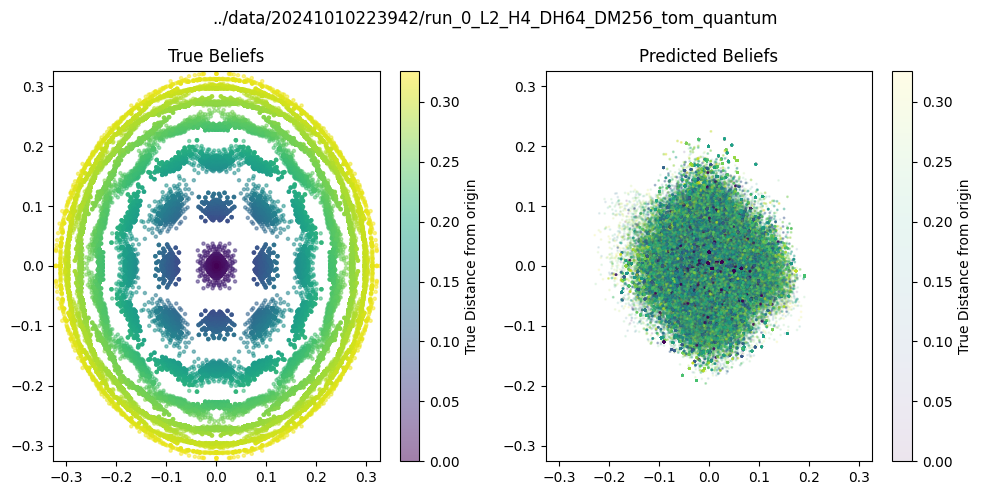

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

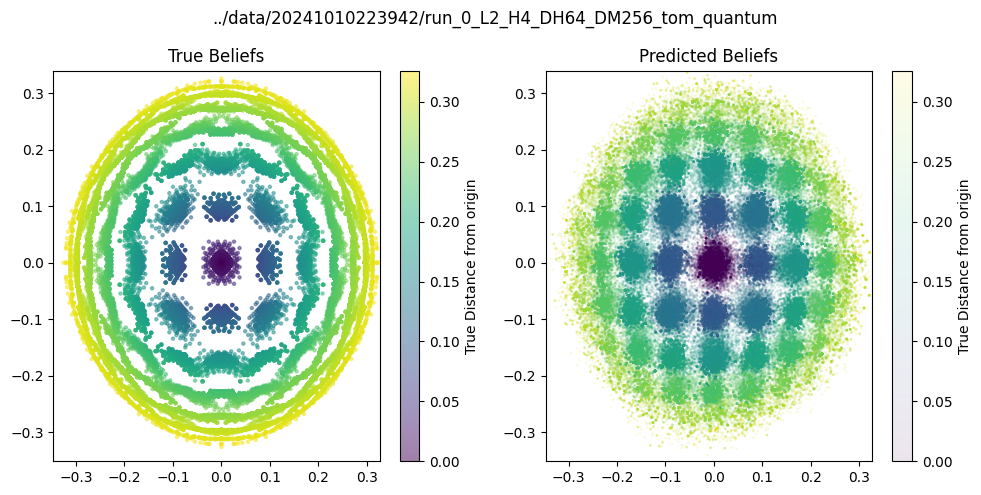

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

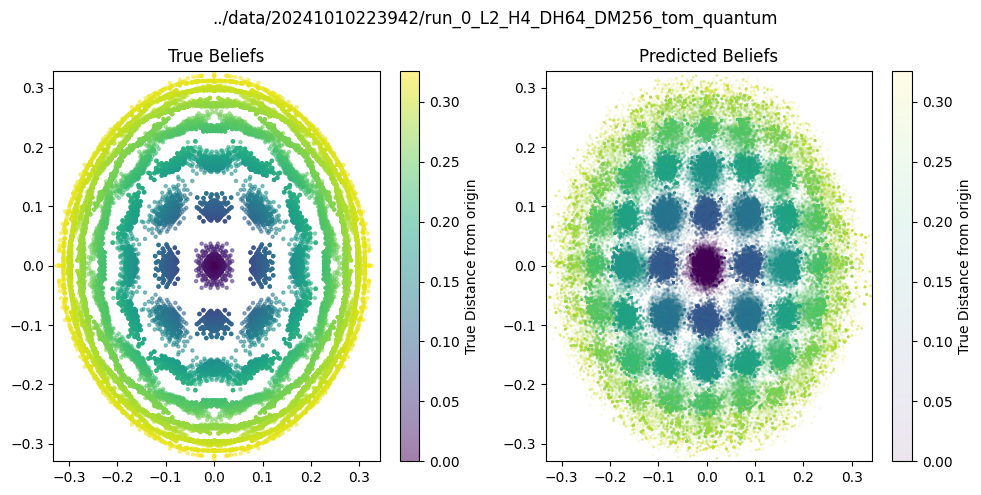

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

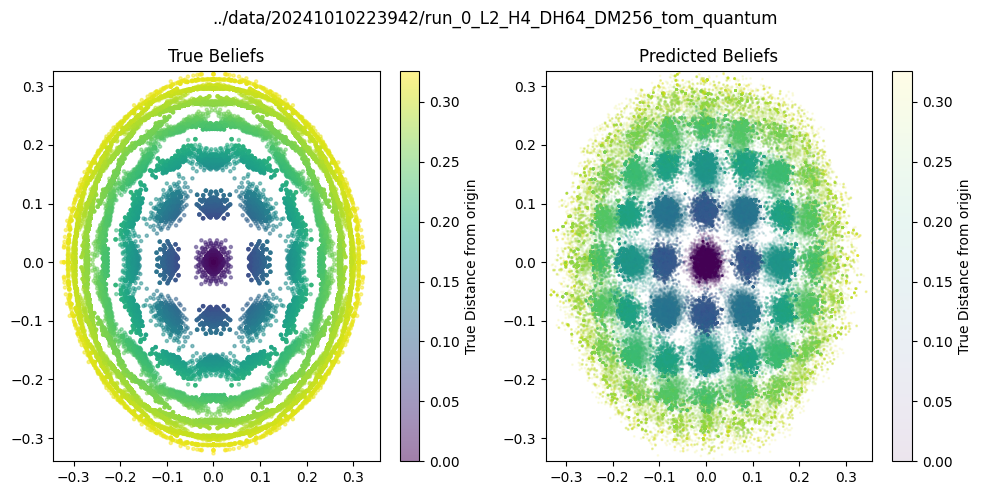

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

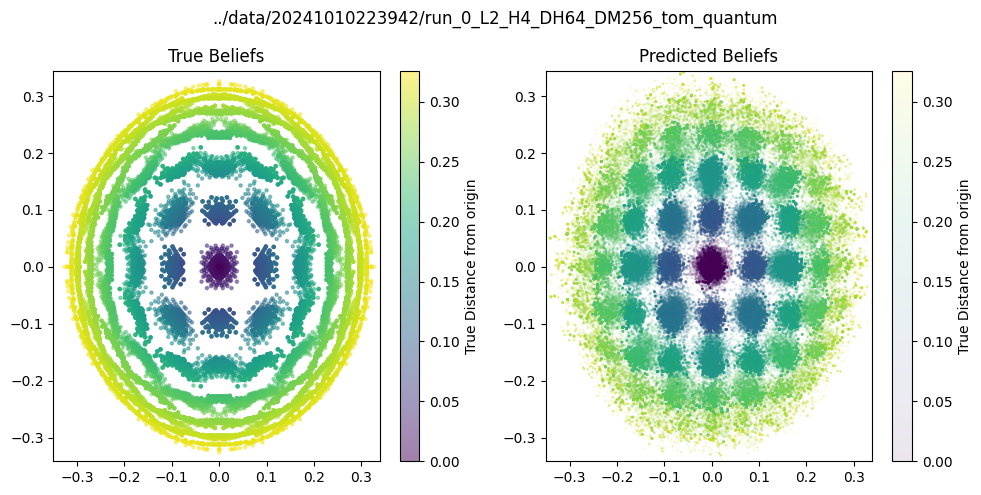

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

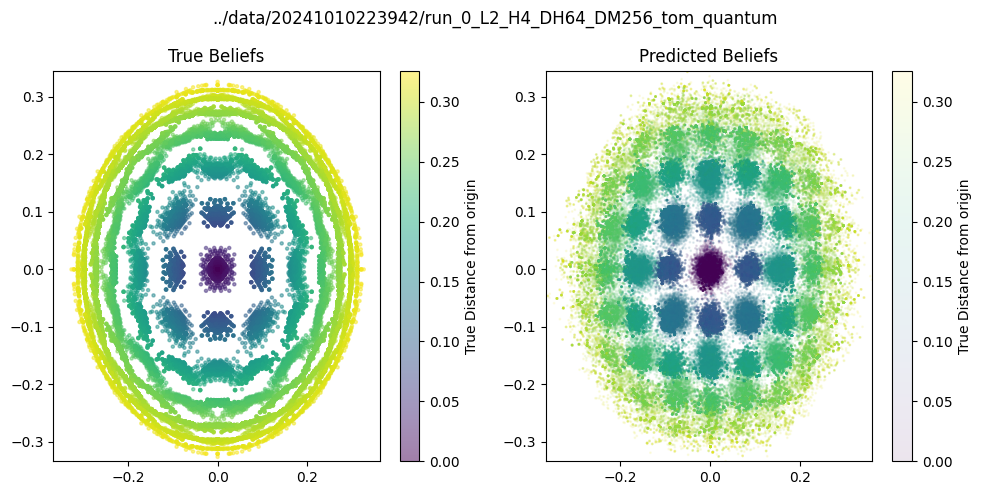

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

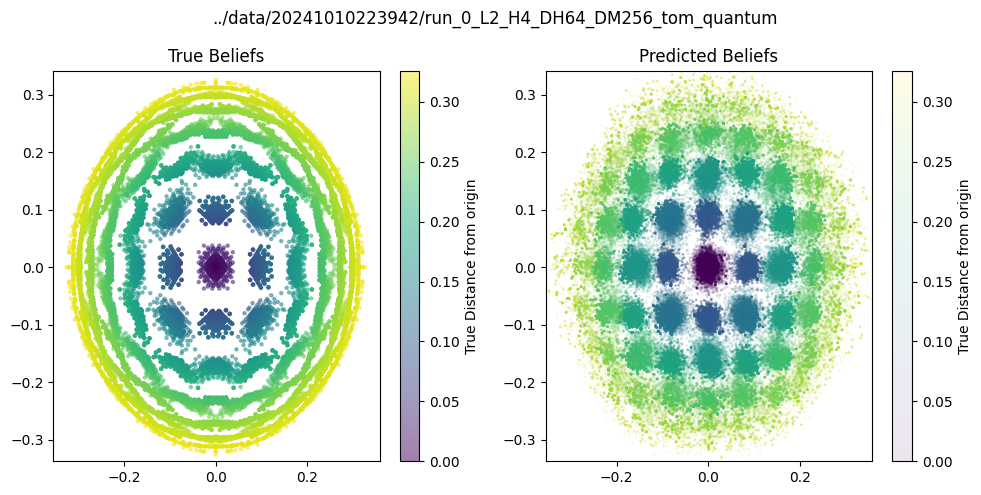

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

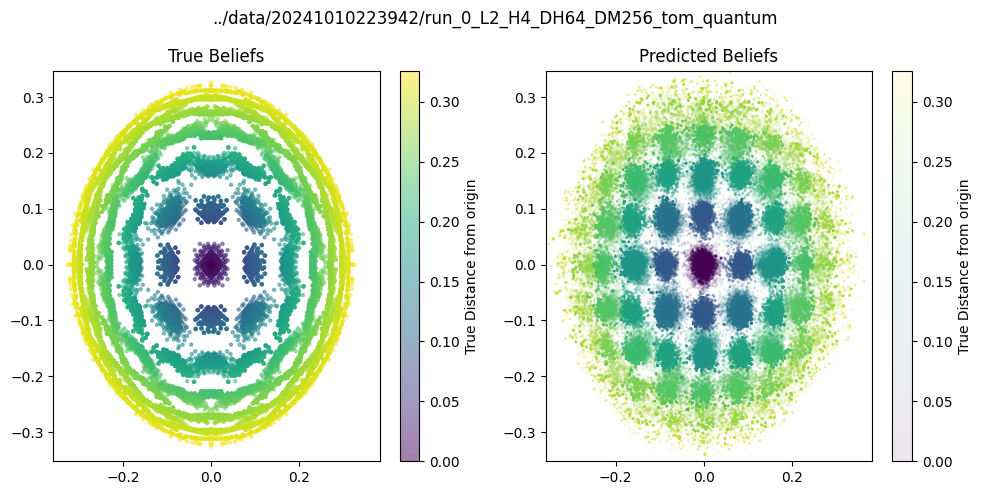

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

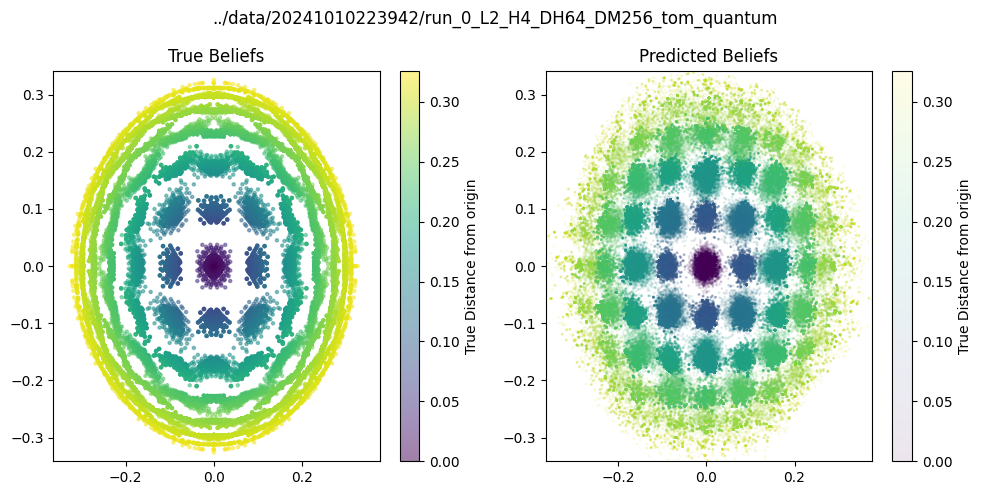

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_5347/296898801.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

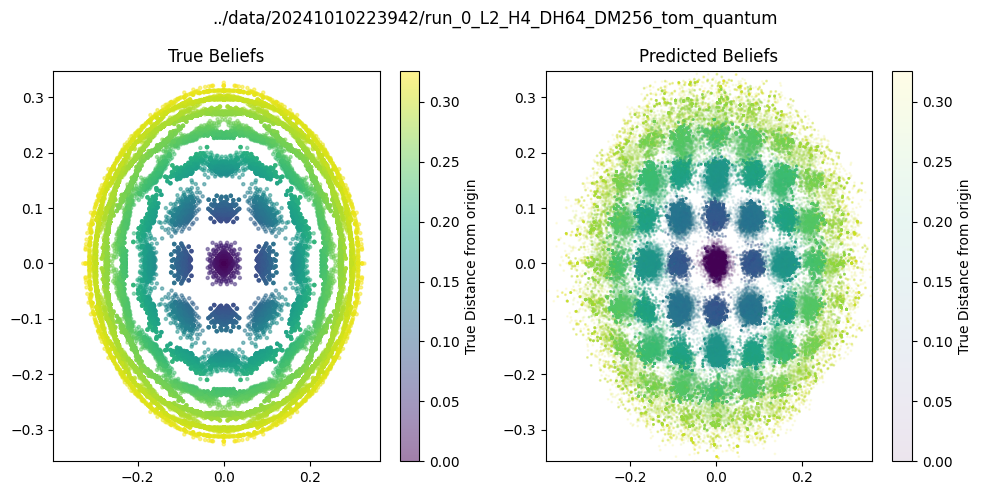

In [32]:
for sweep_folder in sweep_folders:
    model, save_pts, run_config = load_model_from_run_folder(sweep_folder)
    msp = get_msp(run_config)
    tree_paths, tree_beliefs = msp.paths_and_belief_states
    msp_beliefs = [tuple(round(b, 5) for b in belief.squeeze()) for belief in tree_beliefs]
    msp_belief_index = {tuple(b): i for i, b in enumerate(set(msp_beliefs))}
    transformer_inputs = [x for x in tree_paths if len(x) == run_config['model_config']['n_ctx']]
    transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to("cpu")
    transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(torch.tensor(transformer_inputs),
                                                                                                 msp_belief_index,
                                                                                                 tree_paths,
                                                                                                 tree_beliefs)
    n_layers = model.cfg.n_layers
    name_string = f'blocks.{n_layers-1}.hook_resid_post'
    print(f"Running {sweep_folder}")
    type = 'tom' if 'tom' in sweep_folder else 'post' if 'post' in sweep_folder else 'fanizza'
    for mdl in range(0, len(save_pts), 75):
        model = load_model_checkpoint(model, save_pts, mdl)
        all_cache = run_model_with_cache(model, transformer_inputs, act_name=name_string)
        regression, belief_predictions = run_activation_to_beliefs_regression(all_cache[name_string], transformer_input_beliefs)
        plot_belief_predictions(belief_predictions,
                                transformer_input_beliefs,
                                transformer_input_belief_indices,
                                type=type,
                                title=sweep_folder)

